# Сapstone project

In [207]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


In [ ]:
cities = ["Palamos", "Calella de Palafrugell", "Llafranc", "Tamariu", "Pals","Begur", "Cadaques", "Lloret de Mar", "Tossa de Mar", "Blanes", "l'Escala"]

In [208]:
CLIENT_ID = 'VBIFUSZ1E0GYG0HXKB3NVLBY3IODFCCJKCRMJBGX0VN5QXQN' # my Foursquare ID
CLIENT_SECRET = 'ARVMYNBGADWJ1NDS2CTPHXSKEJOIRCM3ZUB4ISQ3TUE4FJ1G' # my Foursquare Secret
VERSION = '20200227'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VBIFUSZ1E0GYG0HXKB3NVLBY3IODFCCJKCRMJBGX0VN5QXQN
CLIENT_SECRET:ARVMYNBGADWJ1NDS2CTPHXSKEJOIRCM3ZUB4ISQ3TUE4FJ1G


In [209]:
#radius
radius = 2000
#list of Id of category in Foursquare
categories_ID = {'Hotel':'4bf58dd8d48988d1fa931735','Food':'4d4b7105d754a06374d81259' , 'Food_Drink_Shop':'4bf58dd8d48988d1f9941735',
                 'Bus_Stop':'52f2ab2ebcbc57f1066b8b4f','Bus Station': '4bf58dd8d48988d1fe931735', 'Train_Station': '4bf58dd8d48988d129951735',
                'Nightlife':'4d4b7105d754a06376d81259', 'Outdoors_Recreation':'4d4b7105d754a06377d81259','Arts_Entertainment':'4d4b7104d754a06370d81259' }

categories_ID

{'Hotel': '4bf58dd8d48988d1fa931735',
 'Food': '4d4b7105d754a06374d81259',
 'Food_Drink_Shop': '4bf58dd8d48988d1f9941735',
 'Bus_Stop': '52f2ab2ebcbc57f1066b8b4f',
 'Bus Station': '4bf58dd8d48988d1fe931735',
 'Train_Station': '4bf58dd8d48988d129951735',
 'Nightlife': '4d4b7105d754a06376d81259',
 'Outdoors_Recreation': '4d4b7105d754a06377d81259',
 'Arts_Entertainment': '4d4b7104d754a06370d81259'}

In [210]:
def get_data(search_query):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(search_query)
    print(search_query)
    latitude = location.latitude
    longitude = location.longitude
    
    frames = []
    for name, category in categories_ID.items():
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT,category)
        results = requests.get(url).json()
        # assign relevant part of JSON to venues
        venues = results['response']['venues']
        # tranform venues into a dataframe
        if(venues!=[]):
            df = json_normalize(venues)
            # add column with main category of vanue
            df['location.main_category'] = name
            #append dataframe of town to list
            frames.append(df)
            
    #concat all frames of venues into one table    
    dataframe = pd.concat(frames, sort=False)
    return dataframe, latitude, longitude

In [211]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [212]:
def feature_selection(dataframe, city):
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    
    # replace all NuN value in the column city by city name
    dataframe_filtered['city'].fillna(city, inplace = True)
    
    # replace all incorrect name of city by actually name
    dataframe_filtered.city.replace(dataframe_filtered.loc[dataframe_filtered['city']!= city].city, city, inplace = True)
    
    # drop unnessecary columns
    dataframe_filtered = dataframe_filtered.drop(["postalCode", "cc", "crossStreet", "state", "country", "labeledLatLngs", "distance", "address"], axis=1, errors='ignore')
    
    # drop city category from list 
    dataframe_filtered = dataframe_filtered[dataframe_filtered.categories != 'City']
    
    # delete None value from categories column
    dataframe_filtered.dropna(subset=['categories'])

    return dataframe_filtered

In [214]:
#list of filtered tables
tables = []
#list of coordinates of cities
coords = []
def get_cities_venues():
    for city in cities:
        dataframe, lat, lng = get_data(city)
        dataframe_filtered =  feature_selection(dataframe, city)
        tables.append(dataframe_filtered)
        coords.append((lat, lng))
    data = pd.concat(tables, sort=False)
    return data

In [215]:
data = get_cities_venues()

In [216]:
data

,name,categories,lat,lng,formattedAddress,address,city,main_category,id
0,Apartaments Palamos-Muntaner,Resort,41.853605,3.125373,[España],NaN,Palamos,Hotel,50145daae4b0649cc1f04107
1,Apartahotel Palamos,Hotel,41.850199,3.121722,[España],NaN,Palamos,Hotel,4e2bdd9518a80bb0585e34f9
2,Trias Hotel,Hotel,41.847977,3.126460,"[Passeig del Mar, s/n, 17230 Palamós Cataluña,...","Passeig del Mar, s/n",Palamos,Hotel,4bd5aaf39649ce72f77c511d
0,El Canó de Palamós,Café,41.846417,3.129282,"[Major, Palamós Cataluña, España]",Major,Palamos,Food,4ff698a6e4b024f559ad227b
1,Pastisseria Gloria Palamos,Dessert Shop,41.848772,3.128126,[España],NaN,Palamos,Food,50327d9ae4b0c5661e58c014
...,...,...,...,...,...,...,...,...,...
10,Lluna Parc,Theme Park,42.116287,3.135759,[España],NaN,l'Escala,Arts_Entertainment,5033e82ae4b05dcb2d2af997
11,La Roca Del Frare,Historic Site,42.122645,3.137693,[España],NaN,l'Escala,Arts_Entertainment,502e825de4b0f8a0004ca9aa
12,La Mar D'en Manassa,General Entertainment,42.127127,3.130864,[España],NaN,l'Escala,Arts_Entertainment,50202aace4b0dabb17b13ad0
13,Dolmen La Talaia,Historic Site,42.122932,3.132093,[España],NaN,l'Escala,Arts_Entertainment,51581199e4b0210cd89f2faa


In [181]:
# create map of town using latitude and longitude values
def map_venues(latitude, longitude, dataframe):
    map_venues = folium.Map(location=[latitude, longitude], zoom_start=14.3)

# add markers to map
    for lat, lng, label in zip(dataframe['lat'], dataframe['lng'], dataframe['name']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_venues)  
    return map_venues

In [217]:
map_venues(coords[0][0], coords[0][1], tables[0])

In [218]:
map_venues(coords[1][0], coords[1][1], tables[1])

In [219]:
map_venues(coords[2][0], coords[2][1], tables[2])

In [220]:
map_venues(coords[3][0], coords[3][1], tables[3])

In [221]:
map_venues(coords[4][0], coords[4][1], tables[4])

In [222]:
map_venues(coords[5][0], coords[5][1], tables[5])

In [223]:
map_venues(coords[6][0], coords[6][1], tables[6])

In [224]:

map_venues(coords[7][0], coords[7][1], tables[7])

In [225]:
map_venues(coords[8][0], coords[8][1], tables[8])

In [226]:
map_venues(coords[9][0], coords[9][1], tables[9])

In [227]:
map_venues(coords[10][0], coords[10][1], tables[10])

In [228]:
# one hot encoding
venue_onehot = pd.get_dummies(data[['categories']], prefix="", prefix_sep="")

# add city column back to dataframe
venue_onehot['city'] = data['city'] 

# move city column to the first column
fixed_columns = [venue_onehot.columns[-1]] + list(venue_onehot.columns[:-1])
venue_onehot = venue_onehot[fixed_columns]

venue_onehot

,city,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Bakery,Bar,...,Trail,Train,Train Station,Turkish Restaurant,Vacation Rental,Village,Vineyard,Volleyball Court,Water Park,Wine Shop
0,Palamos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Palamos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Palamos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Palamos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Palamos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,l'Escala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,l'Escala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,l'Escala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,l'Escala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [229]:
#group venues by cities
venue_grouped = venue_onehot.groupby('city').mean().reset_index()
venue_grouped

,city,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Bakery,Bar,...,Trail,Train,Train Station,Turkish Restaurant,Vacation Rental,Village,Vineyard,Volleyball Court,Water Park,Wine Shop
0,Begur,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000
1,Blanes,0.011765,0.000000,0.00000,0.000000,0.000000,0.023529,0.000000,0.000000,0.023529,...,0.000000,0.0000,0.011765,0.000000,0.011765,0.000000,0.000000,0.000000,0.011765,0.000000
2,Cadaques,0.000000,0.000000,0.00000,0.000000,0.022222,0.022222,0.000000,0.000000,0.044444,...,0.000000,0.0000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000
3,Calella de Palafrugell,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058824,0.0000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000
4,Llafranc,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.068966,0.000000,...,0.034483,0.0000,0.000000,0.000000,0.034483,0.068966,0.000000,0.000000,0.000000,0.000000
5,Lloret de Mar,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011236,...,0.011236,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Palamos,0.000000,0.000000,0.03125,0.000000,0.000000,0.000000,0.031250,0.015625,0.015625,...,0.015625,0.0000,0.000000,0.000000,0.000000,0.015625,0.000000,0.000000,0.000000,0.000000
7,Pals,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,...,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Tamariu,0.000000,0.045455,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.045455,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000
9,Tossa de Mar,0.000000,0.000000,0.00000,0.016393,0.000000,0.000000,0.016393,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016393,0.000000,0.000000


In [230]:
# set number of clusters
kclusters = 5

venue_grouped_clustering = venue_grouped.drop('city', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 0, 1, 4, 1, 1, 0, 2, 3, 1, 0], dtype=int32)

In [231]:
# add clustering labels to table
for i in range(len(venue_grouped)):
    data.loc[data['city'] == venue_grouped['city'][i],'Cluster Labels'] = kmeans.labels_[i]
    
    

In [232]:
data = data.astype({'Cluster Labels': 'int32'})

In [233]:
data

,name,categories,lat,lng,formattedAddress,address,city,main_category,id,Cluster Labels
0,Apartaments Palamos-Muntaner,Resort,41.853605,3.125373,[España],NaN,Palamos,Hotel,50145daae4b0649cc1f04107,0
1,Apartahotel Palamos,Hotel,41.850199,3.121722,[España],NaN,Palamos,Hotel,4e2bdd9518a80bb0585e34f9,0
2,Trias Hotel,Hotel,41.847977,3.126460,"[Passeig del Mar, s/n, 17230 Palamós Cataluña,...","Passeig del Mar, s/n",Palamos,Hotel,4bd5aaf39649ce72f77c511d,0
0,El Canó de Palamós,Café,41.846417,3.129282,"[Major, Palamós Cataluña, España]",Major,Palamos,Food,4ff698a6e4b024f559ad227b,0
1,Pastisseria Gloria Palamos,Dessert Shop,41.848772,3.128126,[España],NaN,Palamos,Food,50327d9ae4b0c5661e58c014,0
...,...,...,...,...,...,...,...,...,...,...
10,Lluna Parc,Theme Park,42.116287,3.135759,[España],NaN,l'Escala,Arts_Entertainment,5033e82ae4b05dcb2d2af997,0
11,La Roca Del Frare,Historic Site,42.122645,3.137693,[España],NaN,l'Escala,Arts_Entertainment,502e825de4b0f8a0004ca9aa,0
12,La Mar D'en Manassa,General Entertainment,42.127127,3.130864,[España],NaN,l'Escala,Arts_Entertainment,50202aace4b0dabb17b13ad0,0
13,Dolmen La Talaia,Historic Site,42.122932,3.132093,[España],NaN,l'Escala,Arts_Entertainment,51581199e4b0210cd89f2faa,0


In [235]:
# create map for clusters
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode('Costa Brava')
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, categ in zip(data['lat'], data['lng'], data['name'], data['Cluster Labels'], data['categories']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Category ' + str(categ), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

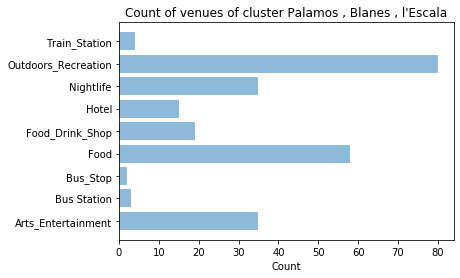

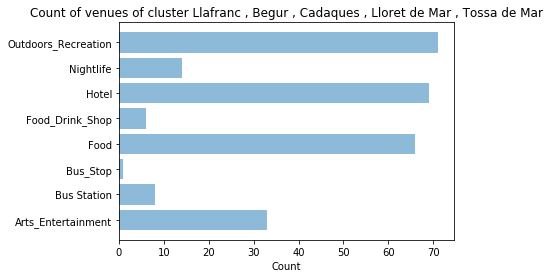

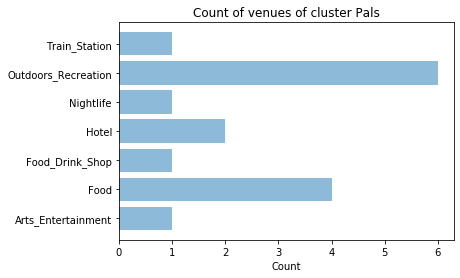

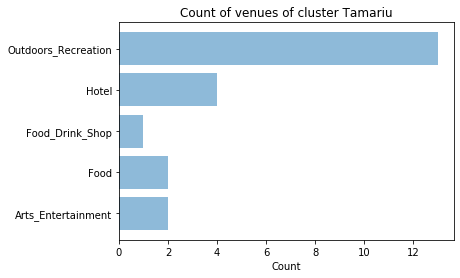

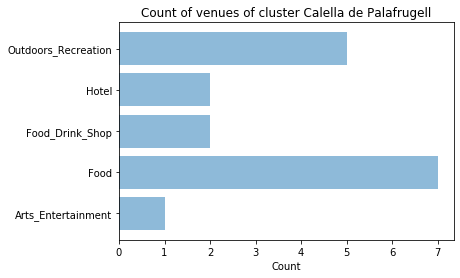

In [236]:
#plot bars for all 5 clusters with their main categories 
def plot_bar(categories, count, cities):
    y_pos = np.arange(len(categories))
    plt.barh(y_pos, count, align='center', alpha=0.5)
    plt.yticks(y_pos, categories)
    plt.xlabel('Count')
    plt.title('Count of venues of cluster ' + cities)
    plt.show()
    
for i in range(5):
    countcateg = data.loc[data['Cluster Labels'] == i].groupby('main_category').count().reset_index()
    cities = ' , '.join(data.loc[data['Cluster Labels'] == i]['city'].unique().tolist())
    plot_bar(countcateg['main_category'], countcateg['city'], cities)

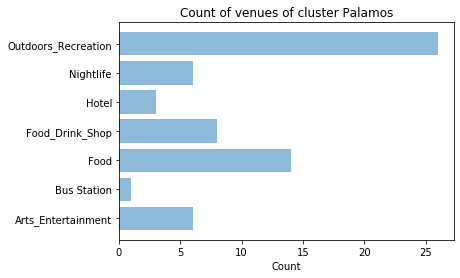

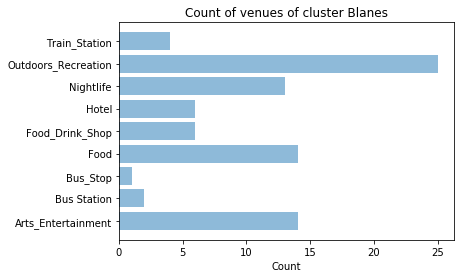

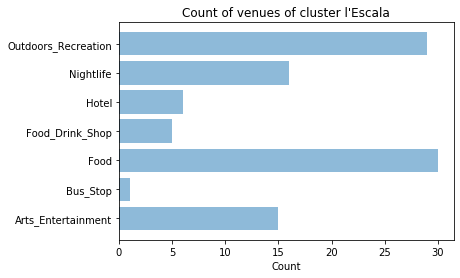

In [239]:
#Get first cluster and plot bars for each city in this cluster
cities = data.loc[data['Cluster Labels'] == 0]['city'].unique().tolist() 
first_cluster = data.loc[data['Cluster Labels'] == 0]

for i in range(len(cities)):
    df = first_cluster.loc[first_cluster['city'] == cities[i]].groupby('main_category').count().reset_index()
    y_pos = np.arange(len(df['main_category']))
    plt.barh(y_pos, df['city'], align='center', alpha=0.5)
    plt.yticks(y_pos, df['main_category'])
    plt.xlabel('Count')
    plt.title('Count of venues of cluster ' + cities[i])
    plt.show()

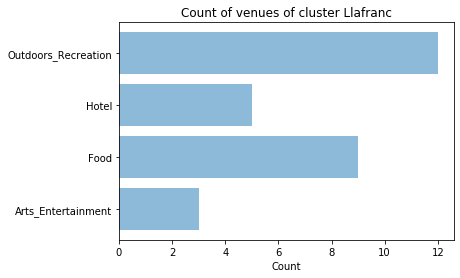

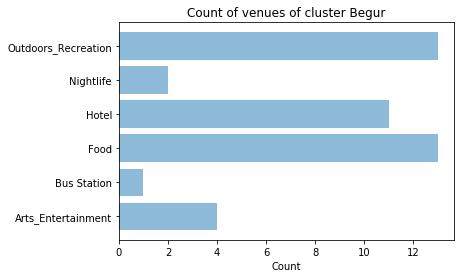

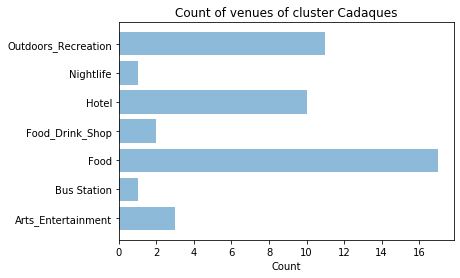

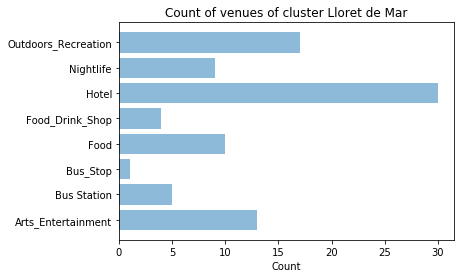

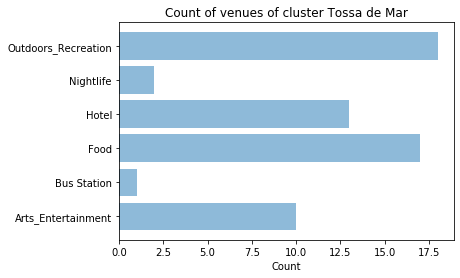

In [240]:
#Get second cluster and plot bars for each city in this cluster
cities = data.loc[data['Cluster Labels'] == 1]['city'].unique().tolist()
first_cluster = data.loc[data['Cluster Labels'] == 1]

for i in range(len(cities)):
    df = first_cluster.loc[first_cluster['city'] == cities[i]].groupby('main_category').count().reset_index()
    y_pos = np.arange(len(df['main_category']))
    plt.barh(y_pos, df['city'], align='center', alpha=0.5)
    plt.yticks(y_pos, df['main_category'])
    plt.xlabel('Count')
    plt.title('Count of venues of cluster ' + cities[i])
    plt.show()

In [ ]:
cit = ['Blanes', 'Tossa de Mar', 'Lloret de Mar', "l'Escala", 'Palamos' , 'Cadaques']

In [241]:
#get list of main categories
categ = data['main_category'].unique().tolist()
categ

['Hotel',
 'Food',
 'Food_Drink_Shop',
 'Bus Station',
 'Nightlife',
 'Outdoors_Recreation',
 'Arts_Entertainment',
 'Train_Station',
 'Bus_Stop']

In [242]:
datafr = pd.DataFrame(columns = categ)

for i in range(len(cit)):
    #add empty rows
    datafr = datafr.append(pd.Series(), ignore_index=True)
#set index by cities    
datafr = datafr.set_index(pd.Index(cit))
#replace NuN to 0
datafr.fillna(0, inplace = True)
datafr

,Hotel,Food,Food_Drink_Shop,Bus Station,Nightlife,Outdoors_Recreation,Arts_Entertainment,Train_Station,Bus_Stop
Blanes,0,0,0,0,0,0,0,0,0
Tossa de Mar,0,0,0,0,0,0,0,0,0
Lloret de Mar,0,0,0,0,0,0,0,0,0
l'Escala,0,0,0,0,0,0,0,0,0
Palamos,0,0,0,0,0,0,0,0,0
Cadaques,0,0,0,0,0,0,0,0,0


In [243]:
#fill table with actual values
for town in cit:
    datacit = data.loc[data['city'] == town].groupby('main_category').count().reset_index()[['main_category','name']]
    for i in range (datacit.shape[0]):
        datafr.at[town , datacit['main_category'][i]]= datacit['name'][i]

        
datafr

,Hotel,Food,Food_Drink_Shop,Bus Station,Nightlife,Outdoors_Recreation,Arts_Entertainment,Train_Station,Bus_Stop
Blanes,6,14,6,2,13,25,14,4,1
Tossa de Mar,13,17,0,1,2,18,10,0,0
Lloret de Mar,30,10,4,5,9,17,13,0,1
l'Escala,6,30,5,0,16,29,15,0,1
Palamos,3,14,8,1,6,26,6,0,0
Cadaques,10,17,2,1,1,11,3,0,0


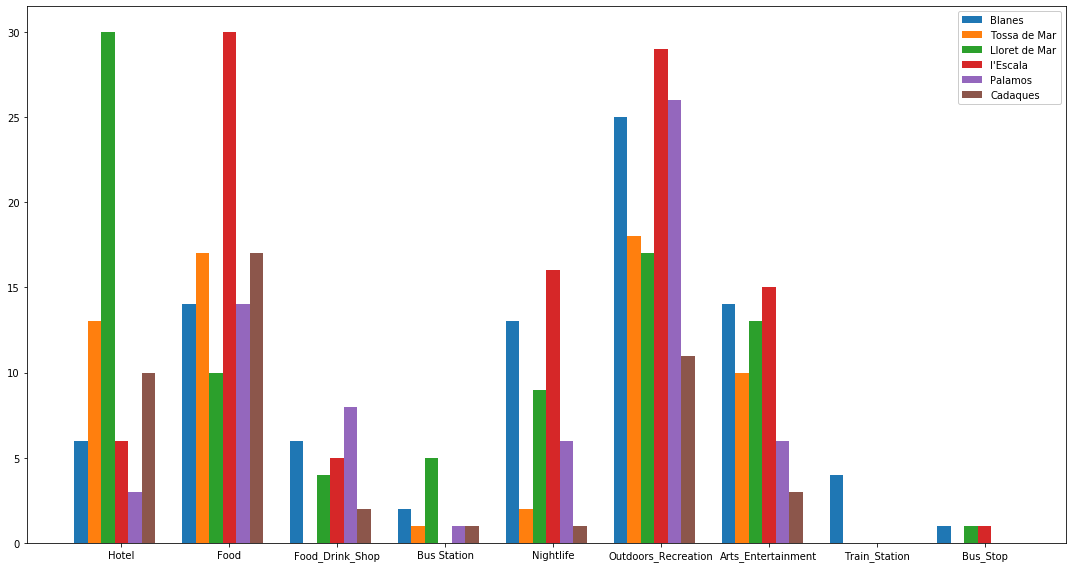

In [244]:
#plot bar for all these towns and main categories
listOfcount = np.array(datafr.values.T.tolist())
x = np.arange(listOfcount.shape[0])
dx = (np.arange(listOfcount.shape[1])-listOfcount.shape[1]/2.)/(listOfcount.shape[1]+2.)
d = 1./(listOfcount.shape[1]+2.)


fig, ax=plt.subplots(figsize=(15,8))
for i in range(listOfcount.shape[1]):
    ax.bar(x+dx[i],listOfcount[:,i], width=d, label=cit[i])

plt.xticks(x, categ)
fig.tight_layout()    
plt.legend(framealpha=4)
plt.show()

In [250]:
pd.DataFrame(data.loc[data['city'] == cit[0]]['main_category'].value_counts()).rename(columns={"main_category": cit[0]})

,Blanes
Outdoors_Recreation,25
Arts_Entertainment,14
Food,14
Nightlife,13
Hotel,6
Food_Drink_Shop,6
Train_Station,4
Bus Station,2
Bus_Stop,1


In [277]:
data.loc[data['city'] == cit[0]].categories.unique()

array(['Resort', 'Hotel', 'Vacation Rental', 'American Restaurant',
       'Coffee Shop', 'Asian Restaurant', 'Pizza Place', 'Restaurant',
       'Falafel Restaurant', 'Mediterranean Restaurant',
       'Italian Restaurant', 'Fast Food Restaurant', 'Sandwich Place',
       'Miscellaneous Shop', 'Supermarket', 'Food & Drink Shop',
       'Bus Stop', 'Bus Station', 'Train Station', 'Platform', 'Pub',
       'Cultural Center', 'Nightclub', 'Bar', 'Hotel Bar', 'Brewery',
       'Cocktail Bar', 'Nightlife Spot', 'Harbor / Marina', 'Beach',
       'Playground', 'Scenic Lookout', 'Other Great Outdoors', 'Park',
       'Cemetery', 'Neighborhood', 'Garden', 'Gym Pool',
       'Martial Arts Dojo', 'Campground', 'Surf Spot', 'Stadium',
       'Theme Park', 'Theater', 'Historic Site', 'General Entertainment',
       'Casino', 'Multiplex', 'Soccer Stadium', 'Racetrack',
       'Bowling Alley', 'Water Park'], dtype=object)

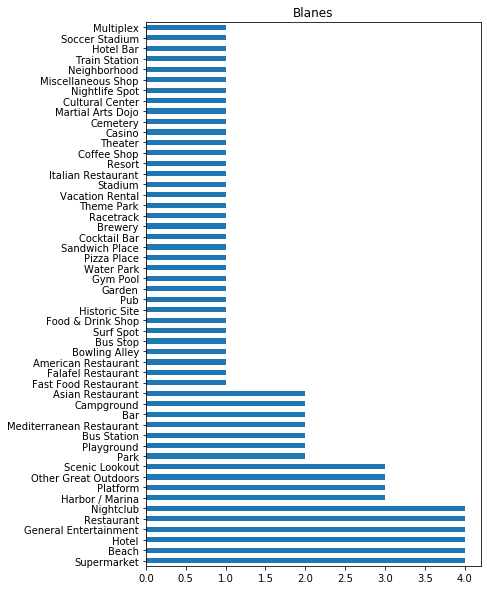

In [247]:
data.loc[data['city'] == cit[0]]['categories'].value_counts().plot(kind='barh', figsize=(6,10), title = cit[0], fontsize= 10)

In [254]:
pd.DataFrame(data.loc[data['city'] == cit[1]]['main_category'].value_counts()).rename(columns={"main_category": cit[1]})

,Tossa de Mar
Outdoors_Recreation,18
Food,17
Hotel,13
Arts_Entertainment,10
Nightlife,2
Bus Station,1


In [281]:
data.loc[data['city'] == cit[1]].categories.unique()

array(['Hotel', 'Motel', 'Resort', 'Bed & Breakfast', 'Tapas Restaurant',
       'Deli / Bodega', 'Spanish Restaurant', 'Mediterranean Restaurant',
       'Restaurant', 'Café', 'Breakfast Spot', 'Bus Station',
       'Sports Bar', 'Lounge', 'Town', 'Castle', 'Beach', 'Plaza',
       'Skate Park', 'Volleyball Court', 'Athletics & Sports', 'Cemetery',
       'Lighthouse', 'Pool', 'Scenic Lookout', 'Gym Pool',
       'History Museum', 'Movie Theater', 'Historic Site',
       'General Entertainment', 'Street Art', 'Concert Hall',
       'Art Gallery'], dtype=object)

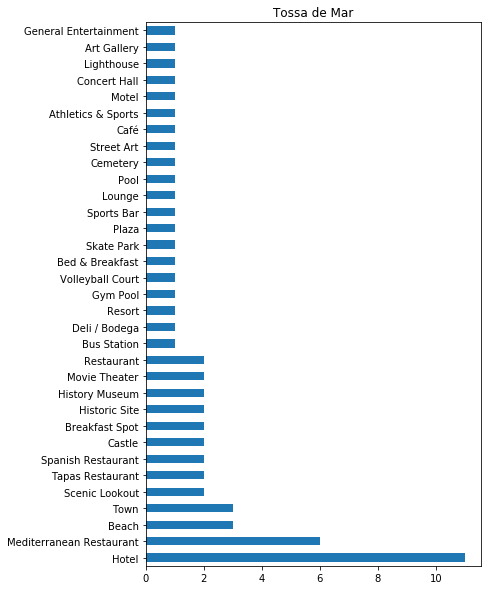

In [155]:
data.loc[data['city'] == cit[1]]['categories'].value_counts().plot(kind='barh', figsize=(6,10), title = cit[1], fontsize= 10)

In [256]:
pd.DataFrame(data.loc[data['city'] == cit[2]]['main_category'].value_counts()).rename(columns={"main_category": cit[2]})

,Lloret de Mar
Hotel,30
Outdoors_Recreation,17
Arts_Entertainment,13
Food,10
Nightlife,9
Bus Station,5
Food_Drink_Shop,4
Bus_Stop,1


In [282]:
data.loc[data['city'] == cit[2]].categories.unique()

array(['Hotel', 'Resort', 'Restaurant', 'Breakfast Spot',
       'Food & Drink Shop', 'Bistro', 'Spanish Restaurant',
       'Mediterranean Restaurant', 'Fast Food Restaurant', 'Café',
       'Supermarket', 'Bus Stop', 'Bus Station', 'Bus Line', 'Lounge',
       'Strip Club', 'Bar', 'Nightclub', 'Hotel Bar', 'Beach',
       'Scenic Lookout', 'Cemetery', 'Other Great Outdoors', 'Trail',
       'Pool', 'Gym / Fitness Center', 'Neighborhood', 'Historic Site',
       'Playground', 'Nudist Beach', 'General Entertainment',
       'Track Stadium', 'Soccer Stadium', 'Casino', 'Racetrack',
       'Theater', 'Roller Rink', 'History Museum', 'Bowling Alley',
       'Hockey Arena'], dtype=object)

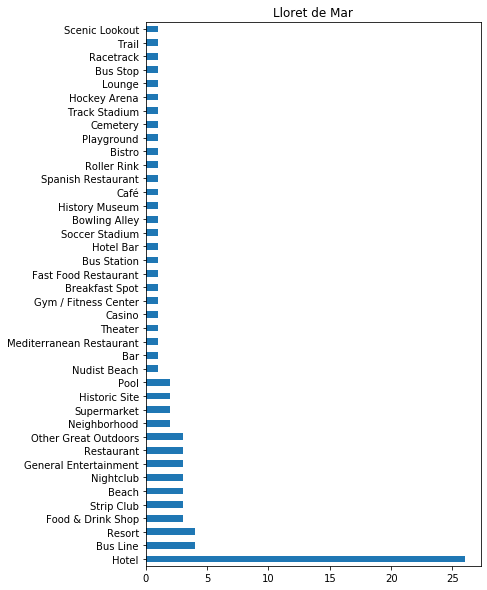

In [154]:
data.loc[data['city'] == cit[2]]['categories'].value_counts().plot(kind='barh', figsize=(6,10), title = cit[2], fontsize= 10)

In [257]:
pd.DataFrame(data.loc[data['city'] == cit[3]]['main_category'].value_counts()).rename(columns={"main_category": cit[3]})

,l'Escala
Food,30
Outdoors_Recreation,29
Nightlife,16
Arts_Entertainment,15
Hotel,6
Food_Drink_Shop,5
Bus_Stop,1


In [ ]:
data.loc[data['city'] == cit[3]].categories.unique()

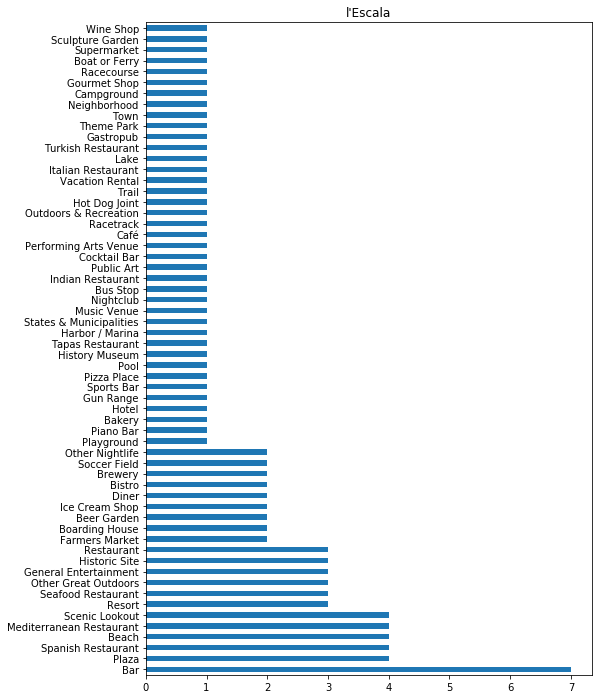

In [150]:
data.loc[data['city'] == cit[3]]['categories'].value_counts().plot(kind='barh', figsize=(8,12), title = cit[3], fontsize= 10)

In [258]:
pd.DataFrame(data.loc[data['city'] == cit[4]]['main_category'].value_counts()).rename(columns={"main_category": cit[4]})

,Palamos
Outdoors_Recreation,26
Food,14
Food_Drink_Shop,8
Arts_Entertainment,6
Nightlife,6
Hotel,3
Bus Station,1


In [283]:
data.loc[data['city'] == cit[4]].categories.unique()

array(['Resort', 'Hotel', 'Café', 'Dessert Shop', 'Diner',
       'Thai Restaurant', 'Cafeteria', 'Tapas Restaurant',
       'Mediterranean Restaurant', 'Restaurant', 'Bakery', 'Snack Place',
       'Seafood Restaurant', 'Butcher', 'Food & Drink Shop',
       'Farmers Market', 'Fish Market', 'Supermarket', 'Bus Station',
       'Dive Bar', 'Strip Club', 'Arcade', 'Bar', 'Speakeasy', 'Town',
       'Park', 'Harbor / Marina', 'Village', 'Gym / Fitness Center',
       'Beach', 'Pool', 'Plaza', 'Playground', 'Skate Park',
       'Athletics & Sports', 'Soccer Field', 'Other Great Outdoors',
       'Campground', 'Trail', 'Lighthouse', 'Music Venue',
       'Movie Theater', 'Historic Site', 'General Entertainment'],
      dtype=object)

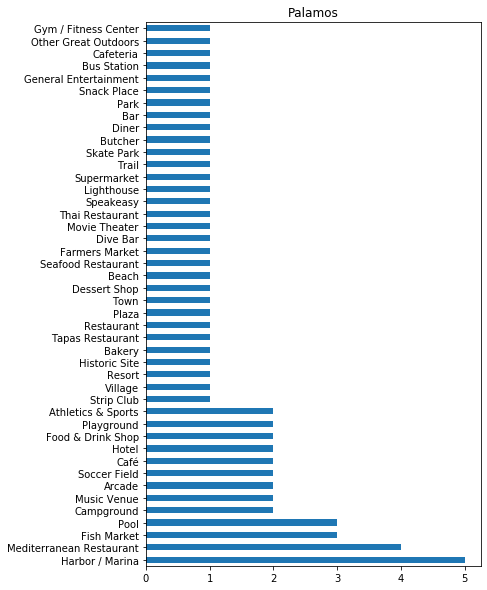

In [146]:
data.loc[data['city'] == cit[4]]['categories'].value_counts().plot(kind='barh',figsize=(6,10), title = cit[4], fontsize= 10)

In [259]:
pd.DataFrame(data.loc[data['city'] == cit[5]]['main_category'].value_counts()).rename(columns={"main_category": cit[5]})

,Cadaques
Food,17
Outdoors_Recreation,11
Hotel,10
Arts_Entertainment,3
Food_Drink_Shop,2
Bus Station,1
Nightlife,1


In [284]:
data.loc[data['city'] == cit[5]].categories.unique()

array(['Hostel', 'Resort', 'Hotel', 'Vacation Rental', 'Tapas Restaurant',
       'Coffee Shop', 'Spanish Restaurant', 'Ice Cream Shop',
       'Deli / Bodega', 'Mediterranean Restaurant', 'Bar', 'Restaurant',
       'Italian Restaurant', 'French Restaurant', 'Breakfast Spot',
       'Asian Restaurant', 'Food & Drink Shop', 'Gourmet Shop',
       'Bus Station', 'Town', 'Beach', 'Harbor / Marina', 'Soccer Field',
       'Campground', 'Field', 'Art Museum', 'History Museum', 'Jazz Club'],
      dtype=object)

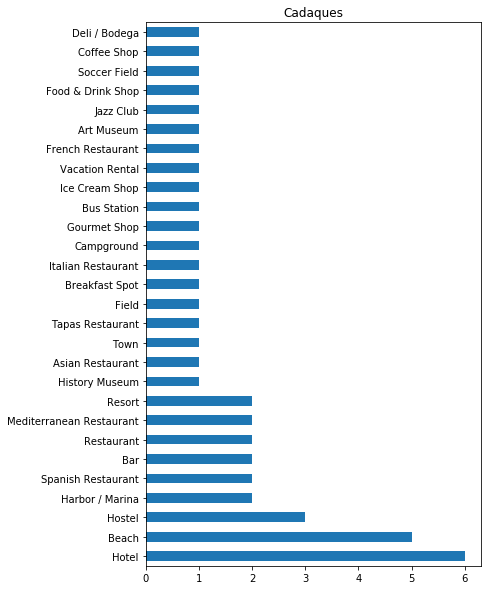

In [143]:
data.loc[data['city'] == cit[5]]['categories'].value_counts().plot(kind='barh', figsize=(6,10), title = cit[5], fontsize= 10)

In [262]:
pd.DataFrame(data.loc[data['categories'] == 'Beach']['city'].value_counts()).rename(columns={"city": 'Beach'})

,Beach
Cadaques,5
Blanes,4
l'Escala,4
Lloret de Mar,3
Tamariu,3
Tossa de Mar,3
Llafranc,2
Palamos,1
Begur,1


In [269]:
pd.DataFrame(data.loc[data['categories'] == 'Hotel']['city'].value_counts()).rename(columns={"city": 'Hotel'})

,Hotel
Lloret de Mar,26
Tossa de Mar,11
Begur,10
Cadaques,6
Llafranc,5
Blanes,4
Palamos,2
Calella de Palafrugell,2
Tamariu,1
Pals,1


In [268]:
pd.DataFrame(data.loc[data['categories'].str.contains("Restaurant")]['city'].value_counts()).rename(columns={"city": 'Restaurant'})

,Restaurant
l'Escala,18
Blanes,12
Tossa de Mar,12
Cadaques,10
Begur,10
Palamos,8
Lloret de Mar,6
Llafranc,3
Calella de Palafrugell,3
Tamariu,2


In [272]:
pd.DataFrame(data.loc[data['main_category'] == 'Nightlife']['city'].value_counts()).rename(columns={"city": 'Nightlife'})

,Nightlife
l'Escala,16
Blanes,13
Lloret de Mar,9
Palamos,6
Begur,2
Tossa de Mar,2
Pals,1
Cadaques,1


In [279]:
pd.DataFrame(data.loc[data['categories'] == 'Playground']['city'].value_counts()).rename(columns={"city": 'Playground'})

,Playground
Palamos,2
Blanes,2
Llafranc,1
Lloret de Mar,1
l'Escala,1


In [280]:
pd.DataFrame(data.loc[data['main_category'] == 'Food_Drink_Shop']['city'].value_counts()).rename(columns={"city": 'Food_Drink_Shop'})

,Food_Drink_Shop
Palamos,8
Blanes,6
l'Escala,5
Lloret de Mar,4
Cadaques,2
Calella de Palafrugell,2
Pals,1
Tamariu,1
